In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
# from deep_translator import GoogleTranslator

from tqdm import tqdm

plt.style.use('ggplot')

import nltk
from nltk.tokenize import word_tokenize
# from LeIA import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
# from spellchecker import SpellChecker

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, DatasetDict, Dataset

from google_play_scraper import Sort, reviews, app

C:\Users\rayss\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rayss\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
apps_ids = ['br.com.brainweb.ifood', 'com.cerveceriamodelo.modelonow',

'com.mcdo.mcdonalds', 'habibs.alphacode.com.br',

'com.ubercab.eats', 'com.grability.rappi',

'burgerking.com.br.appandroid', 

'com.vanuatu.aiqfome',

'br.com.sbf.centauro',

'br.com.riachuelo.app',

'com.mercadolibre',

'com.cerveceriamodelo.modelonow',

'com.amazon.mShop.android.shopping',

'br.gov.meugovbr',

'com.b2w.americanas',

'br.com.lojasrenner',

'br.com.marisa.android',

'com.zzkko',

'com.luizalabs.mlapp']

In [4]:
apps_reviews = []

for ap in tqdm(apps_ids):
    for score in list(range(1, 6)):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='pt',
                country='br',
                sort=sort_order,
                count= 200 if score == 3 else 100,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            apps_reviews.extend(rvs)

100%|██████████| 19/19 [01:02<00:00,  3.28s/it]


In [5]:
df = pd.DataFrame(apps_reviews)

In [6]:
df = df.drop(['reviewId'], axis=1)
df['id'] = range(1, len(df) + 1)

In [7]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,RYBADI GAMER,https://play-lh.googleusercontent.com/a-/ALV-U...,As últimas atualizações deixaram o aplicativo ...,1,49,10.24.0,2024-07-15 20:18:23,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,74,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,90,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,15,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,73,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


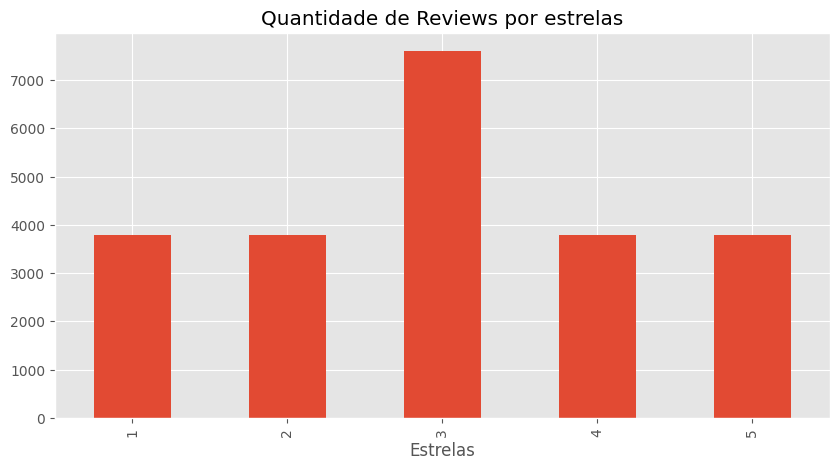

In [8]:
ax = df['score'].value_counts().sort_index().plot(kind='bar', title='Quantidade de Reviews por estrelas', figsize=(10, 5))
ax.set_xlabel('Estrelas')
plt.show()

### NLTK Básico

In [9]:
WORD_MIN_LENGTH = 2
STOP_WORDS_PT = [stop_word.lower() for stop_word in nltk.corpus.stopwords.words('portuguese')]
spell = SpellChecker(language='pt')

def strip_accents(text):
    nfkd = unicodedata.normalize('NFKD', text)
    stripped_text = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    return re.sub('[^a-zA-Z]', ' ', stripped_text)

def tokenize(text):
    text = strip_accents(text)
    text = re.sub(re.compile('\n'),' ',text)
    words = word_tokenize(text)
    words = [word.lower() for word in words]
    words = [word for word in words if word not in STOP_WORDS_PT and len(word) >= WORD_MIN_LENGTH]
    return words

def lemmatize(text):
    lemmatized_text = []
    for (word) in text:
        lemmatizing = str(WordNetLemmatizer().lemmatize(word))
        lemmatized_text.append(lemmatizing)
    return lemmatized_text

def preprocess_stl(array):
    preprocessed = []

    stripped_rvs = [strip_accents(rvs) for rvs in array]
    tokenized_rvs = [tokenize(rvs) for rvs in stripped_rvs]
    lemmatized_rvs = [lemmatize(rvs) for rvs in tokenized_rvs]

    preprocessed = lemmatized_rvs

    return preprocessed



## Utilizando VADER
Abordagem BoW - removeremos stop words e cada palavra remeterá a uma pontuação e essas pontuações serão combinadas para obter uma pontuação final

In [10]:
sia = SentimentIntensityAnalyzer()
translator = GoogleTranslator(source='pt', target='en')

In [11]:
def translate_and_analyze(text, myid):
    try:
        translated_text = translator.translate(text)
        if translated_text is None:
            raise ValueError("Translation returned None")
        sentiment = sia.polarity_scores(translated_text)
        return myid, sentiment
    except Exception as e:
        return myid, {"error": str(e)}

In [12]:
df_sample = df.sample(n=500, random_state=42)

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

In [13]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId,id
0,RYBADI GAMER,https://play-lh.googleusercontent.com/a-/ALV-U...,As últimas atualizações deixaram o aplicativo ...,1,49,10.24.0,2024-07-15 20:18:23,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,1
1,Guilherme Gomes,https://play-lh.googleusercontent.com/a/ACg8oc...,Um lixo de aplicativo. Cada vez mais a experiê...,1,74,10.24.0,2024-07-08 17:11:27,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,2
2,Guidi Yu,https://play-lh.googleusercontent.com/a-/ALV-U...,O atendimento pelo chat no geral era bom. Hoje...,1,90,10.24.0,2024-07-05 21:21:42,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,3
3,Luis Martins,https://play-lh.googleusercontent.com/a/ACg8oc...,Estou bem decepcionado com o app. É cada vez m...,1,15,10.24.0,2024-07-13 17:02:54,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,4
4,Igor Fernandez,https://play-lh.googleusercontent.com/a/ACg8oc...,"Com certeza um dos piores apps que tenho, volu...",1,73,10.24.0,2024-07-04 19:58:07,None,NaT,10.24.0,most_relevant,br.com.brainweb.ifood,5


In [14]:
# vaders = pd.DataFrame(res).T
# vaders.reset_index(inplace=True)
# vaders = vaders.rename(columns={'index': 'id'})
# vaders = vaders.merge(df, how='left', on='id')

In [15]:
vaders = vaders.drop(['userImage', 'reviewCreatedVersion', 'replyContent', 'sortOrder', 'thumbsUpCount', 'at', 'repliedAt', 'appVersion', 'userName'], axis=1)

In [16]:
vaders.head()

In [17]:
vaders = vaders.dropna(subset=['pos', 'neg', 'neu'])

In [18]:
vaders.to_csv('./vaders.csv')

In [19]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Pontuação compound por review de produto em estrelas')
plt.show()

Quando menor a pontuação compound, menor a quantidade de estrelas dada pelo consumidor.

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])

axs[0].set_title('Positivo')
axs[1].set_title('Neutro')
axs[2].set_title('Negativo')

plt.tight_layout()
plt.show()

## Utilizando BERT

In [187]:
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from scipy.special import softmax

In [188]:
# MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [189]:
# Exemplo executado para VADER

example = df['content'][0]
# vader_result = sia.polarity_scores(example)

# print(example)
# print(vader_result)

#### Exemplo de classificação com BERT

In [190]:
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

result = classifier(example)

print(result)


[{'label': '1 star', 'score': 0.8262738585472107}]


### Agora realizamos o fine-tuning do BERT para os interesses de classificar as emoções em 'alegria', 'satisfação', 'neutro', 'decepção' e 'raiva'

Vamos rotular as linhas do dataframe para utilizar este para treinar o modelo, fazendo o fine-tuning deste

In [191]:
df_to_semilabel = df.drop(['userImage', 'reviewCreatedVersion', 'replyContent', 'sortOrder', 'thumbsUpCount', 'at', 'repliedAt', 'appVersion', 'userName'], axis=1)
df_to_semilabel

,content,score,appId,id
0,As últimas atualizações deixaram o aplicativo ...,1,br.com.brainweb.ifood,1
1,Um lixo de aplicativo. Cada vez mais a experiê...,1,br.com.brainweb.ifood,2
2,O atendimento pelo chat no geral era bom. Hoje...,1,br.com.brainweb.ifood,3
3,Estou bem decepcionado com o app. É cada vez m...,1,br.com.brainweb.ifood,4
4,"Com certeza um dos piores apps que tenho, volu...",1,br.com.brainweb.ifood,5
...,...,...,...,...
22795,"Excelente, entregas antes do prazo previsto.",5,com.luizalabs.mlapp,22796
22796,Comprar pelo app é ótimo acesso é fácil e rápi...,5,com.luizalabs.mlapp,22797
22797,Perfeito,5,com.luizalabs.mlapp,22798
22798,"Todas, desde o atendimento até as entregas",5,com.luizalabs.mlapp,22799


In [192]:
df_to_semilabel.to_csv('./df_to_semilabel.csv')

In [193]:
# Essas são as emoções que queremos classificar - ou ausência de emoção, no caso de ser um comentário neutro
labels = ["raiva", "decepção", "neutro", "satisfação", "alegria"]

In [194]:
df_semilabeled

,Unnamed: 0,content,emotion,score,appId,id
0,0,Já é a segunda vez que tento resolver um probl...,raiva,1,br.com.brainweb.ifood,1
1,1,Um lixo de aplicativo. Cada vez mais a experiê...,raiva,1,br.com.brainweb.ifood,2
2,2,O atendimento pelo chat no geral era bom. Hoje...,raiva,1,br.com.brainweb.ifood,3
3,3,Estou bem decepcionado com o app. É cada vez m...,decepção,1,br.com.brainweb.ifood,4
4,4,"Com certeza um dos piores apps que tenho, volu...",decepção,1,br.com.brainweb.ifood,5
...,...,...,...,...,...,...
22795,22795,Muito bom,satisfação,5,com.luizalabs.mlapp,22796
22796,22796,"Muito prático e sem burocracia, fácil entendim...",satisfação,5,com.luizalabs.mlapp,22797
22797,22797,"Amo o atendimento,os produtos e tudo mais ... ...",alegria,5,com.luizalabs.mlapp,22798
22798,22798,Ótimo site de compras. Parabéns,satisfação,5,com.luizalabs.mlapp,22799


In [195]:
df_semilabeled = pd.read_csv('./df_semilabeled.csv')
df_semilabeled = df_semilabeled.dropna(subset=['emotion'])
df_train = df_semilabeled[df_semilabeled['emotion'] != 'deletar']

In [196]:
df_train.shape

(1012, 6)

In [197]:
df_train = df_train.drop(['Unnamed: 0', 'appId', 'id', 'score'], axis=1)

In [198]:
df_extra_rvs = pd.read_csv('./more_reviews.csv')
df_extra_rvs.shape

(600, 2)

In [199]:
df_train = pd.concat([df_train, df_extra_rvs], ignore_index=True)

In [200]:
df_train.shape

(1612, 2)

In [201]:
print(f"Quantidade de avaliações com teor sentimental 'satisfação': {len(df_train[df_train['emotion'] == 'satisfação'])}")
print(f"Quantidade de avaliações com teor sentimental 'alegria': {len(df_train[df_train['emotion'] == 'alegria'])}")
print(f"Quantidade de avaliações com teor sentimental 'neutro': {len(df_train[df_train['emotion'] == 'neutro'])}")
print(f"Quantidade de avaliações com teor sentimental 'decepção': {len(df_train[df_train['emotion'] == 'decepção'])}")
print(f"Quantidade de avaliações com teor sentimental 'raiva': {len(df_train[df_train['emotion'] == 'raiva'])}")

Quantidade de avaliações com teor sentimental 'satisfação': 354
Quantidade de avaliações com teor sentimental 'alegria': 409
Quantidade de avaliações com teor sentimental 'neutro': 37
Quantidade de avaliações com teor sentimental 'decepção': 426
Quantidade de avaliações com teor sentimental 'raiva': 386


In [202]:
df_test = df_to_semilabel[~df_to_semilabel['content'].isin(df_train['content'])]
df_test = df_test.drop(['appId', 'id', 'score'], axis=1)


In [203]:
# Criando um mapa para as emoções de interesse da análise

emotion_dict = {
    'raiva': 0,
    'decepção': 1,
    'neutro': 2,
    'satisfação': 3,
    'alegria': 4
}

df_train['emotion'] = df_train['emotion'].map(emotion_dict)

In [204]:
df_train.isnull().values.any()

False

In [205]:


# df_train['emotion'] = df_train['emotion'].astype(int)

# Agora temos números inteiros como emoções

In [206]:
df_train['emotion'].isna().any()

False

In [207]:
df_train[df_train.isna().any(axis=1)]

,content,emotion


In [208]:
# Transformando os DataFrames em datasets Hugging Face

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [209]:
# Função para tokenizar as avaliações

def tokenize_function(df):
    return tokenizer(df['content'], padding='max_length', truncation=True)


In [210]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 21107/21107 [00:15<00:00, 1389.98 examples/s]


In [211]:
# Custom Data Collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [212]:
# Hugging Face espera que coluna alvo tenha o nome labels
train_dataset = train_dataset.rename_column("emotion", "labels")

In [213]:
# Configurando argumentos de treinamento
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

In [214]:
trainer.train()

  2%|▏         | 10/606 [02:32<2:26:37, 14.76s/it]

{'loss': 0.8108, 'grad_norm': 5.217069625854492, 'learning_rate': 1.966996699669967e-05, 'epoch': 0.05}


  3%|▎         | 20/606 [05:00<2:23:00, 14.64s/it]

{'loss': 0.5958, 'grad_norm': 9.635065078735352, 'learning_rate': 1.9339933993399344e-05, 'epoch': 0.1}


  5%|▍         | 30/606 [07:27<2:21:46, 14.77s/it]

{'loss': 0.7479, 'grad_norm': 10.161713600158691, 'learning_rate': 1.900990099009901e-05, 'epoch': 0.15}


  7%|▋         | 40/606 [09:54<2:18:08, 14.64s/it]

{'loss': 0.6761, 'grad_norm': 19.034194946289062, 'learning_rate': 1.867986798679868e-05, 'epoch': 0.2}


  8%|▊         | 50/606 [12:20<2:15:55, 14.67s/it]

{'loss': 0.4466, 'grad_norm': 12.13599681854248, 'learning_rate': 1.8349834983498352e-05, 'epoch': 0.25}


 10%|▉         | 60/606 [14:47<2:12:42, 14.58s/it]

{'loss': 0.505, 'grad_norm': 23.370983123779297, 'learning_rate': 1.8019801980198022e-05, 'epoch': 0.3}


 12%|█▏        | 70/606 [17:14<2:10:56, 14.66s/it]

{'loss': 0.6324, 'grad_norm': 17.16060447692871, 'learning_rate': 1.768976897689769e-05, 'epoch': 0.35}


 13%|█▎        | 80/606 [19:40<2:07:51, 14.59s/it]

{'loss': 0.613, 'grad_norm': 12.303902626037598, 'learning_rate': 1.735973597359736e-05, 'epoch': 0.4}


 15%|█▍        | 90/606 [22:07<2:06:20, 14.69s/it]

{'loss': 0.3725, 'grad_norm': 9.984989166259766, 'learning_rate': 1.702970297029703e-05, 'epoch': 0.45}


 17%|█▋        | 100/606 [24:33<2:02:22, 14.51s/it]

{'loss': 0.371, 'grad_norm': 5.652854919433594, 'learning_rate': 1.66996699669967e-05, 'epoch': 0.5}


 18%|█▊        | 110/606 [26:59<2:00:49, 14.62s/it]

{'loss': 0.4409, 'grad_norm': 1.0051225423812866, 'learning_rate': 1.6369636963696372e-05, 'epoch': 0.54}


 20%|█▉        | 120/606 [29:25<1:58:08, 14.58s/it]

{'loss': 0.5467, 'grad_norm': 9.560953140258789, 'learning_rate': 1.6039603960396042e-05, 'epoch': 0.59}


 21%|██▏       | 130/606 [31:52<1:56:06, 14.63s/it]

{'loss': 0.571, 'grad_norm': 15.523921966552734, 'learning_rate': 1.570957095709571e-05, 'epoch': 0.64}


 23%|██▎       | 140/606 [34:19<1:53:54, 14.67s/it]

{'loss': 0.5101, 'grad_norm': 1.2164018154144287, 'learning_rate': 1.537953795379538e-05, 'epoch': 0.69}


 25%|██▍       | 150/606 [36:46<1:51:54, 14.72s/it]

{'loss': 0.449, 'grad_norm': 9.264450073242188, 'learning_rate': 1.504950495049505e-05, 'epoch': 0.74}


 26%|██▋       | 160/606 [39:13<1:48:08, 14.55s/it]

{'loss': 0.4679, 'grad_norm': 22.689300537109375, 'learning_rate': 1.4719471947194721e-05, 'epoch': 0.79}


 28%|██▊       | 170/606 [41:39<1:46:03, 14.59s/it]

{'loss': 0.4986, 'grad_norm': 19.949867248535156, 'learning_rate': 1.438943894389439e-05, 'epoch': 0.84}


 30%|██▉       | 180/606 [44:06<1:44:13, 14.68s/it]

{'loss': 0.3961, 'grad_norm': 7.093743324279785, 'learning_rate': 1.405940594059406e-05, 'epoch': 0.89}


 31%|███▏      | 190/606 [46:33<1:42:28, 14.78s/it]

{'loss': 0.6085, 'grad_norm': 3.1967921257019043, 'learning_rate': 1.372937293729373e-05, 'epoch': 0.94}


 33%|███▎      | 200/606 [49:00<1:39:04, 14.64s/it]

{'loss': 0.3229, 'grad_norm': 8.141802787780762, 'learning_rate': 1.33993399339934e-05, 'epoch': 0.99}


 33%|███▎      | 202/606 [49:23<1:25:17, 12.67s/it]

ValueError: Trainer: evaluation requires an eval_dataset.

In [ ]:
# inputs = tokenizer(example, return_tensors='pt', padding=True, truncation=True)
# outputs = model(**inputs)
# scores = outputs.logits[0].detach().numpy()
# scores = softmax(scores)
# predicted_label = labels[scores.argmax()]
# print(scores)
# print(scores.argmax())
# print(predicted_label)

In [ ]:
# def predict_emotion(text):
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
#     outputs = model(**inputs)
#     scores = outputs.logits[0].detach().numpy()
#     scores = softmax(scores)
#     predicted_label = labels[scores.argmax()]
#     return predicted_label


# df_labeled['predicted_emotion'] = df_labeled['content'].apply(predict_emotion)